## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%load_ext autoreload
%autoreload 2
!pip install --quiet ray pickle5
from google.colab import drive
drive.mount('/content/gdrive/')
!cp -r /content/gdrive/MyDrive/Colab\ Notebooks/otfb-lhc-ml/* ./
import pickle5 as pickle

     |████████████████████████████████| 54.5 MB 57.9 MB/s 
     |████████████████████████████████| 256 kB 47.9 MB/s 
     |████████████████████████████████| 144 kB 37.5 MB/s 
     |████████████████████████████████| 8.8 MB 39.3 MB/s 
     |████████████████████████████████| 4.1 MB 32.8 MB/s 
     |████████████████████████████████| 461 kB 34.4 MB/s 
Mounted at /content/gdrive/


In [11]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from pytorchClassifiers import Net


In [2]:
# with open('data/transfer-functions-82000.pkl', "rb") as fh:
#     raw_data = pickle.load(fh)
# Load the data
# df = pd.DataFrame(raw_data)
df = pd.read_pickle('./data/transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.001000,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-19.88111092306877, -24.65165651883909, -18.7..."
1,-20.0,0.001088,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.868232696282362, -17.698964676040426, -16..."
2,-20.0,0.001185,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-17.300864575069816, -25.87749055893209, -28...."
3,-20.0,0.001289,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-15.239813657422143, -28.608066399706654, -24..."
4,-20.0,0.001403,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-18.40240405493654, -20.57374582325774, -24.8..."


In [3]:

phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)

print(df.dtypes)


[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.001      0.0010884  0.00118461 0.00128933 0.0014033  0.00152735
 0.00166237 0.00180932 0.00196926 0.00214334 0.00233281 0.00253902
 0.00276347 0.00300776 0.00327364 0.00356302 0.00387799 0.00422079
 0.00459391 0.005     ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


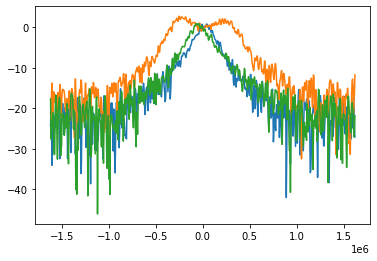

In [4]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [5]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [6]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

target = torch.tensor(target, dtype=torch.uint8)
print(target[5:15])

tensor([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14]], dtype=torch.uint8)


In [7]:
values = np.zeros((len(df), len(df.iloc[0, 0])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row.values[0]
    index += 1
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [8]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
scaled_values = data_scaler.transform(values)
data = torch.tensor(scaled_values)
print(data)

tensor([[-0.5378, -0.8267, -0.2371,  ..., -0.1169, -0.1908, -1.1691],
        [-0.8251, -0.1174, -0.0605,  ..., -0.5932, -1.5411, -1.1238],
        [-0.2897, -0.9517, -1.2612,  ..., -0.4935, -0.5153, -0.2053],
        ...,
        [ 2.1191,  1.8198,  1.9688,  ...,  2.6293,  2.1272,  2.4447],
        [ 1.5838,  1.2171,  0.5005,  ...,  0.6547,  1.2669,  1.4611],
        [ 1.1176,  0.9647,  1.1369,  ...,  1.5023,  1.1669,  0.6056]])


In [9]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(
    data, target, target_original, test_size=0.2, random_state=2)

# further divide X_test in test + validate
X_test, X_validate, y_test, y_validate, y_test_original, y_validate_original = train_test_split(
    X_test, y_test, y_test_original, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

torch.Size([65600, 662])
torch.Size([13120, 662])
torch.Size([3280, 662])
torch.Size([65600, 2])
torch.Size([13120, 2])
torch.Size([3280, 2])


In [10]:
# Initialize model, loss function and optimizer
def train_model(config, X_train, y_train, X_test, y_test, name, epochs,
                checkpoint_dir=None):
    
    # if 'stride' not in config and 'kernel_size' in config:
    #     config['stride'] = config['kernel_size']

    n_inputs = X_train.shape[1]
    
    # we will build one model per output target
    n_outputs = len(np.unique(y_test))
    model = Net(n_inputs, n_outputs, name=name,
                with_batch_norm=True, save_best=False, 
                verbose=0, **config)

    # specify loss function (regression)
    criterion = nn.NLLLoss()

    # specify optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    # print(model)


    # train the network
    for epoch in range(epochs):
        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
            optimizer, criterion, X_train, y_train, X_test, y_test, 1)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(accuracy=test_accuracy[-1], loss=test_loss[-1])

    return model, train_loss, test_loss, train_accuracy, test_accuracy

In [ ]:
# configuring the search space
config = {
    "activation_func": tune.choice([F.gelu, F.relu]),
    "avg_pool": tune.choice([(6,6)]),
    "hidden_1": tune.choice([480, 500, 520]),
    "hidden_2": tune.choice([180, 200, 220]),
    # "hidden_3": tune.choice([0]),
    "trim_edges": tune.choice([130, 135, 140]),
}

scheduler = ASHAScheduler(
    max_t=100,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
    tune.with_parameters(train_model,
                         X_train=X_train, y_train=y_train[:,0].view(-1,),
                         X_test=X_test, y_test=y_test[:,0].view(-1,),
                         name='model1', epochs=50),
    resources_per_trial={"cpu": 1},
    config=config,
    metric='accuracy',
    mode='max',
    num_samples=50,
    scheduler=scheduler,
    progress_reporter=reporter)


2022-06-30 11:15:41,521	INFO trial_runner.py:803 -- starting train_model_367ce_00000


== Status ==
Current time: 2022-06-30 11:15:41 (running for 00:00:00.31)
Memory usage on this node: 14.9/14.9 GiB: ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 0/0 GPUs, 0.0/1.22 GiB heap, 0.0/0.61 GiB objects
Result logdir: /home/kiliakis/ray_results/train_model_2022-06-30_11-15-41
Number of trials: 16/50 (15 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------------+-----------------------------------+------------+------------+------------+--------------+
| Trial name              | status   | loc                   | activation_func    

2022-06-30 11:15:47,046	INFO trial_runner.py:803 -- starting train_model_367ce_00001


In [89]:
results_df = result.results_df.sort_values('accuracy', ascending=False)
results_df.drop(columns=['time_this_iter_s', 'should_checkpoint', 'done', 
                        'timesteps_total', 'episodes_total', 'experiment_id', 
                        'time_since_restore', 'timesteps_since_restore', 
                        'iterations_since_restore', 'warmup_time', 
                        'experiment_tag'], inplace=True)
results_df.drop(columns=['timestamp', 'time_total_s', 'pid', 'hostname', 
                         'node_ip'], inplace=True)
print(results_df)

              accuracy      loss  training_iteration                 date  \
trial_id                                                                    
ae718_00045  32.240854  1.787318                  50  2022-06-24_09-05-18   
ae718_00000  31.257622  1.799332                  50  2022-06-24_09-00-43   
ae718_00006  19.641768  2.352236                  16  2022-06-24_08-59-15   
ae718_00008  14.283537  2.674124                   8  2022-06-24_08-59-48   
ae718_00021  13.452744  2.728689                   8  2022-06-24_09-01-36   
ae718_00023  13.140244  2.742292                   8  2022-06-24_09-01-46   
ae718_00031  13.003049  2.727978                   8  2022-06-24_09-02-37   
ae718_00043  12.881098  2.733721                   8  2022-06-24_09-03-22   
ae718_00012  11.913110  2.789290                   8  2022-06-24_09-00-43   
ae718_00017   8.399390  3.091795                   4  2022-06-24_09-01-06   
ae718_00042   7.804878  3.155393                   4  2022-06-24_09-03-06   

In [90]:
columns = results_df.columns.values.astype(str).tolist()
values = results_df.values
# values = np.sort(values, lambda a: -a[0])
# Prepare the values
values[:, 5] = np.apply_along_axis(lambda v: ''.join(
    str(v[5])).replace('(', '').replace(')', ''), 1, values)
values = values.astype(str)
values[:, 4] = np.apply_along_axis(lambda e: e[4].replace(
    '<built-in function ', '').replace('>', ''), 1, values)


In [91]:
base_path = '/content/gdrive/MyDrive/Colab Notebooks/otfb-lhc-ml/hyperopt/'
if not os.path.exists(base_path):
    os.makedirs(base_path)

import csv
with open(os.path.join(base_path, f'{values[0, 3]}.csv'), 'w') as file:
    writer = csv.writer(file)
    writer.writerow(columns)
    writer.writerows(values)
